<a href="https://www.kaggle.com/code/ceyhunsahin/rus-gridsearch-private-score-0-4?scriptVersionId=139921856" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score, f1_score, accuracy_score,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
def target_corrs(df):
    '''List of correlations'''
    corrs = []

    # Iterate through the columns
    for col in df.columns:
        # Skip the target column
        if col != 'Class':
            # Calculate correlation with the target
            corr = df['Class'].corr (df[col])

            # Append the list as a tuple
            corrs.append ((col, corr))

    # Sort by absolute magnitude of correlations
    corrs = sorted (corrs, key=lambda x: abs (x[1]), reverse=True)

    return corrs

In [3]:
def kde_target(df, var_name, target='Class'):
    '''Plots the distribution of a variable colored by value of the target'''

    # Calculate the correlation coefficient between the new variable and the target
    corr = df[target].corr (df[var_name])
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df[target] == 0, var_name].median ()
    avg_not_repaid = df.loc[df[target] == 1, var_name].median ()

    plt.figure (figsize=(12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot (df.loc[df[target] == 0, var_name], label='Class == 0')
    sns.kdeplot (df.loc[df[target] == 1, var_name], label='Class == 1')

    # label the plot
    plt.xlabel (var_name);
    plt.ylabel ('Density')
    plt.title ('%s Distribution' % var_name)
    plt.legend ()

    # print out the correlation
    print ('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))


In [4]:
def Pie_chart(df) :
    tot_null =  df.isna().sum().sum()
    prop = tot_null*100/(df.shape[0]*df.shape[1])
    data = [prop,100-prop]

    labels = ['Null', 'Donnée']
    colors = sns.color_palette('bright')
    plt.figure(figsize=(15,8))
    plt.pie(data, colors = colors, autopct = '%0.0f%%',labels=labels,)
    plt.title('Taux de Remplissage')
    plt.show()

In [5]:
def remplissage(df):
    df_sort = pd.DataFrame(round(df.shape[0] - df.isna().sum())/df.shape[0],columns=\
                               ['Taux_de_remplissage']).sort_values('Taux_de_remplissage', ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(10,30))
    
    sns.barplot(y=df_sort['index'], x='Taux_de_remplissage', data=df_sort)

    plt.title('Taux de remplissage des variables - %', fontsize = 30)
    plt.show()

In [6]:
filepath = '/kaggle/input/icr-identify-age-related-conditions'
df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

df_train['EJ'] = df_train['EJ'].replace({'A': 0, 'B': 1})

df_test['EJ']  = df_test['EJ'].replace({'A': 0, 'B': 1})
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
df_train.dropna()
df_test.dropna()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


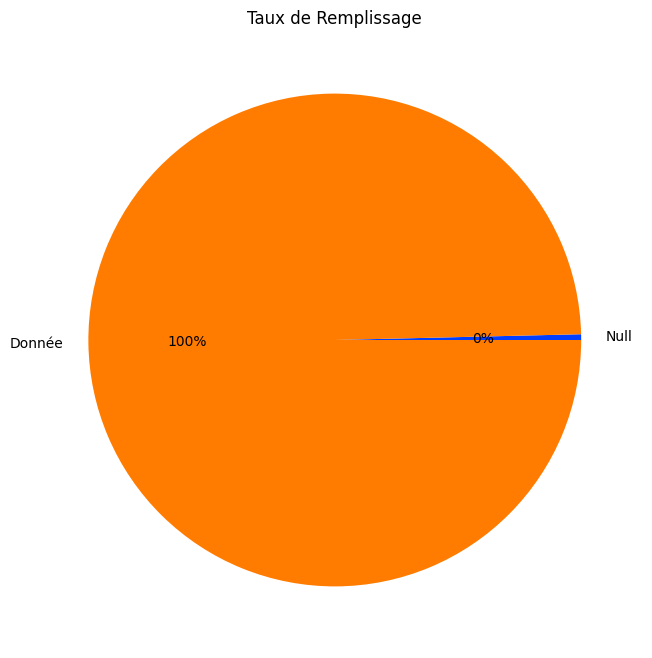

In [8]:
Pie_chart(df_train)

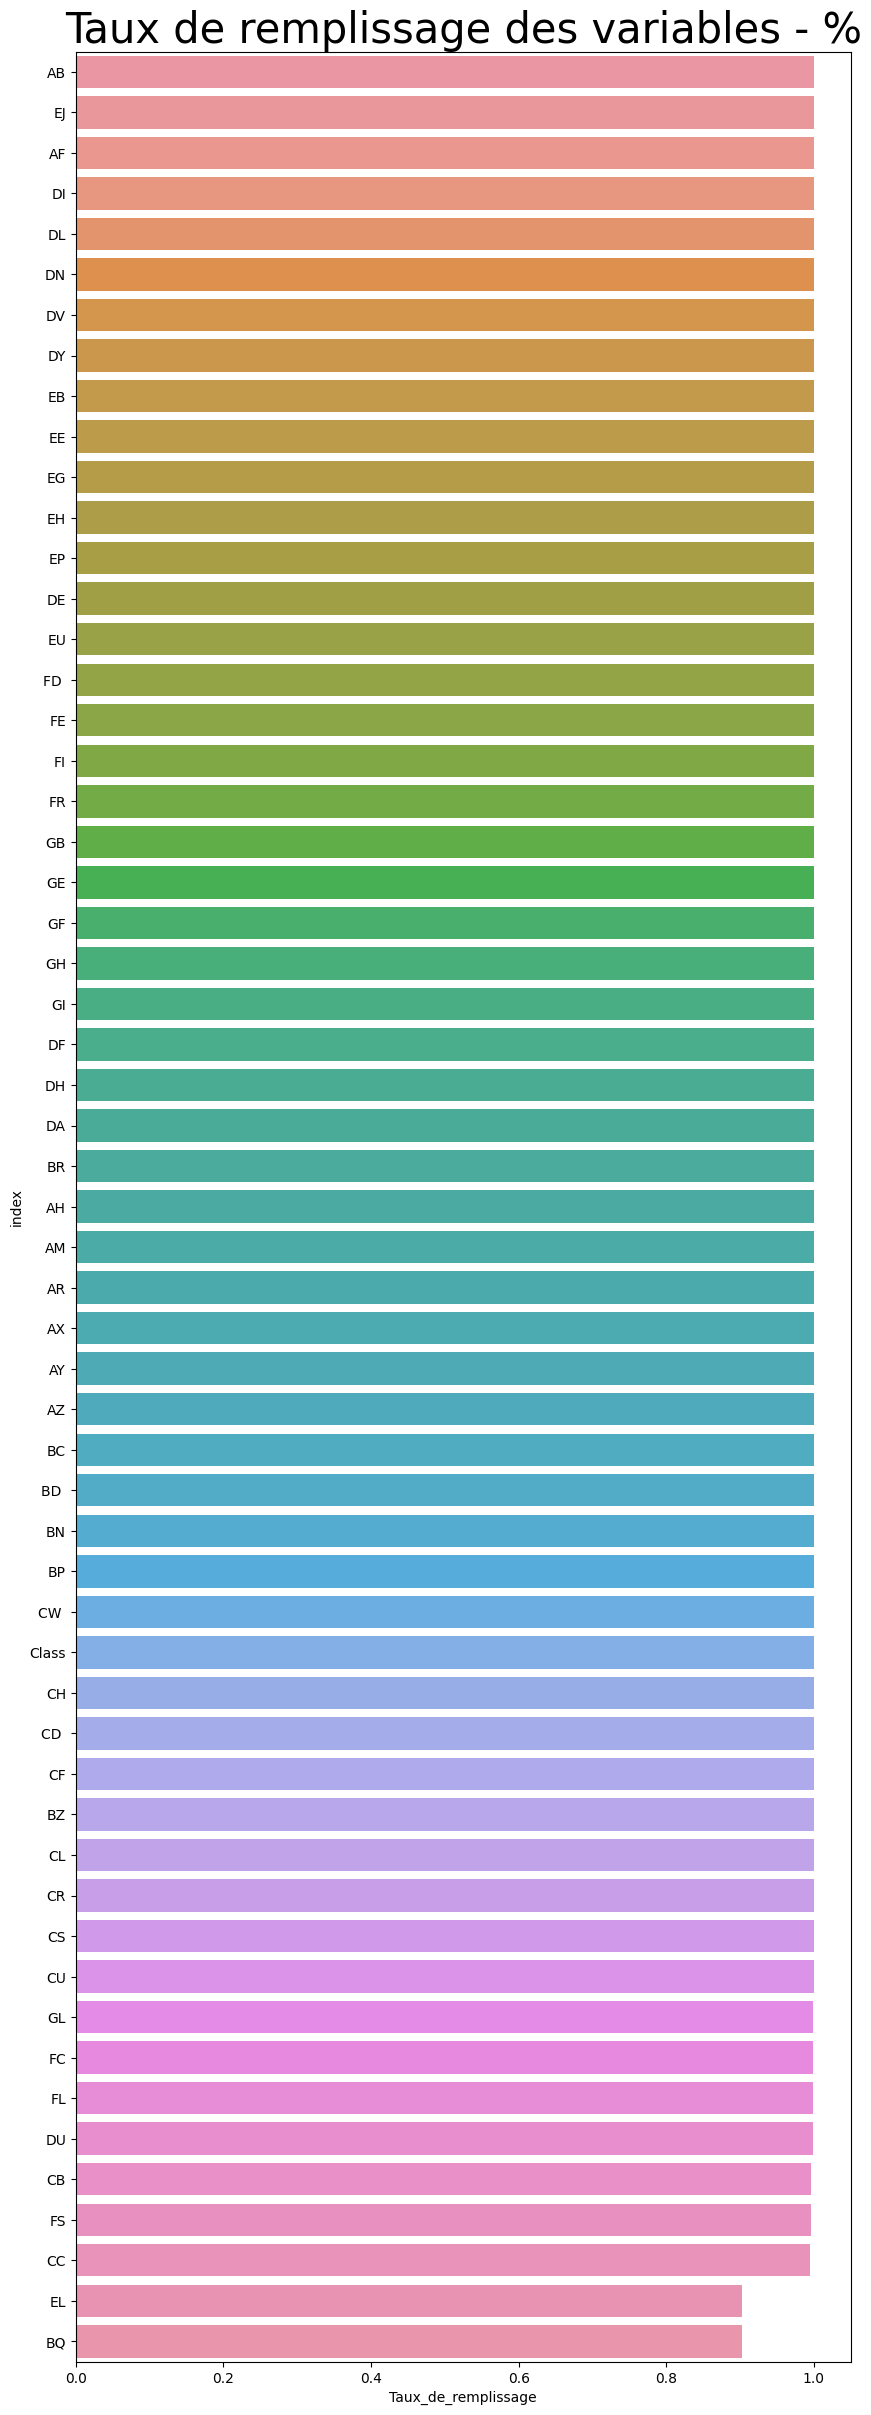

In [9]:
remplissage(df_train)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 000ff2bfdfe9 to ffcca4ded3bb
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    

In [11]:
df_train.describe(include = 'all')

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [12]:
def list_features_att(df):
    '''Function to attribute to columns of a dataframe a category into a several list
    it returns two lists.
    --> Numerical: num_list
    --> discrete_numerical: num_dis_list'''

    num_list = list()
    num_dis_list = list()
    for name in df.columns:
        if df[name].nunique() < 10:
            num_dis_list.append(name)
        else:
            num_list.append(name)
    return num_list, num_dis_list


In [13]:
target_corrs(df_train)

[('AF', 0.30263845295706254),
 ('BQ', 0.2812569498557066),
 ('AB', 0.2806118820146081),
 ('DU', 0.26100043678278256),
 ('DI', 0.26075980571986845),
 ('FL', 0.24418542013351094),
 ('AM', 0.23916993156241662),
 ('CR', -0.22754659276787195),
 ('FE', 0.21635913044648242),
 ('DH', -0.2068392454005764),
 ('DA', -0.2046120370858707),
 ('BN', 0.19828288876105485),
 ('EH', 0.17985530672037958),
 ('CD ', 0.17130354932075312),
 ('BP', 0.15728644290909433),
 ('BC', 0.1558815349542324),
 ('DL', -0.14771602038439668),
 ('EE', -0.13532354428920096),
 ('FD ', 0.13109958646851286),
 ('GF', -0.1282080340502062),
 ('DE', -0.12497729147482405),
 ('GL', -0.11920221573167994),
 ('BZ', 0.11242330489019955),
 ('BD ', 0.11218407269891827),
 ('CF', 0.1097477461204545),
 ('FR', 0.10409912152603568),
 ('AX', 0.09761578296404438),
 ('EJ', 0.09650037449717225),
 ('FI', -0.09432709836698473),
 ('BR', 0.08855356255112842),
 ('EB', 0.08800491810535996),
 ('GB', 0.08334316250342874),
 ('CU', -0.08318486460783603),
 ('A

The correlation between DU and the TARGET is 0.2610


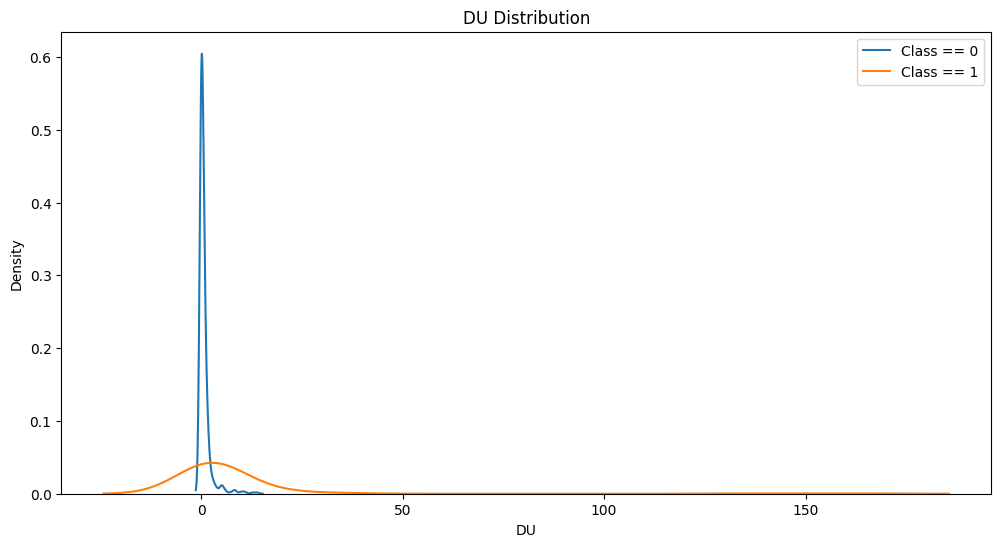

In [14]:
kde_target(df_train, 'DU', target='Class')

In [15]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)
X = df_train.drop('Class', axis = 1)
y = df_train['Class']

In [16]:
# Imputation in function of the numeric format
numerical_cont_list, numerical_disc_list = list_features_att(X)
time_init = time.time()
#imputation on numeric continue columns with 'mean' strategy
X[numerical_cont_list] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cont_list]) # mean

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
)

0    509
1    108
Name: Class, dtype: int64


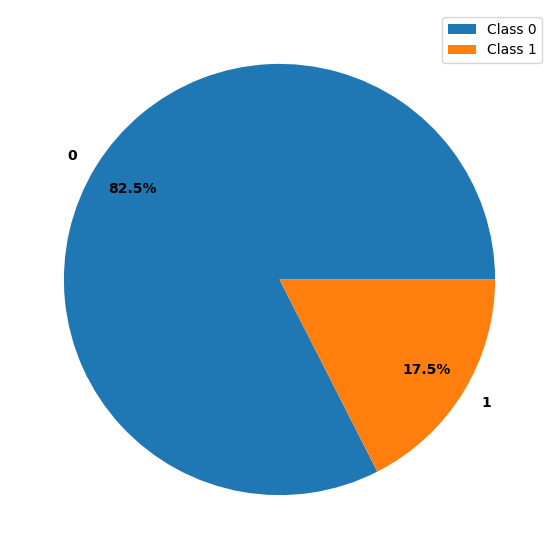

In [18]:
figure1 = plt.figure(figsize=(10,7), facecolor='w')
plt.axis('off')
x = y.value_counts()
print(x)

plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.legend(['Class 0', 'Class 1'])
plt.show()

In [19]:
y.isna().sum()

0

In [20]:
from sklearn.metrics import make_scorer, fbeta_score
def modelPipelineGrid(X_train, X_test, y_train, y_test, step1):
    scores_Cv = []
    rs = {'random_state': 42}
    log_reg = LogisticRegression(**rs)
    nb = BernoulliNB()
    knn = KNeighborsClassifier()
    svm = SVC(**rs)
    mlp = MLPClassifier(max_iter=500, **rs)
    dt = DecisionTreeClassifier(**rs)
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    lgbm = LGBMClassifier(**rs)

    xgb_params = {'n_estimators':range(5,100,5), 'max_depth': [5, 7, 10,15], 'learning_rate':[0.1, 0.05]}

    log_reg_params = {'C': [0.1, 3, 50]}

    knn_params = {'n_neighbors':range(2,200,2)}

    random_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10]}

    lgbm_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10], 'learning_rate':[0.1, 0.5]}

    dt_params = {'criterion' : ['gini', 'entropy'],  'max_depth' : [2,4,6,8,10]}

    svm_params = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    # Define the scoring metric
    scorer = make_scorer(fbeta_score, beta=2)

    clfs = [
           # ('Logistic Regression', log_reg,log_reg_params),
            #('K-Nearest Neighbors', knn,knn_params),
            #('SVM', svm,svm_params),
            ('Decision Tree', dt,dt_params),
            ('Random Forest', rf,random_params),
            ('XGBoost', xgb,xgb_params),
            ('LGBMClassifier', lgbm,lgbm_params)
            ]
    if step1 == 'over' :
        Imb_Method = SMOTE(random_state=42)
    if step1 == 'under' :
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy = 'auto',replacement=True)
    for clf_name, clf, param_grid in clfs:

        pipe = Pipeline(steps=[
                                   ('step1', Imb_Method),
                                   ('classifier', clf)
                                   ]
                            )

        search = GridSearchCV(pipe, {f'classifier__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},cv = 5, scoring=scorer)
        search.fit(X_train, y_train)
        scores_Cv.append({'model':clf_name, 'best_score ROC_AUC':search.best_score_, 'best parameters':search.best_params_,
                          'Best model':search.best_estimator_,'Refit Time(s)':search.refit_time_, 'Comment':f'{Imb_Method} train data'})

    return scores_Cv

In [21]:
ScoresGridSearch = modelPipelineGrid(X_train, X_test, y_train, y_test, 'under')
ScoresGridSearch

[{'model': 'Decision Tree',
  'best_score ROC_AUC': 0.7079839847408761,
  'best parameters': {'classifier__criterion': 'entropy',
   'classifier__max_depth': 6},
  'Best model': Pipeline(steps=[('step1',
                   RandomUnderSampler(random_state=42, replacement=True)),
                  ('classifier',
                   DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                          random_state=42))]),
  'Refit Time(s)': 0.02162623405456543,
  'Comment': 'RandomUnderSampler(random_state=42, replacement=True) train data'},
 {'model': 'Random Forest',
  'best_score ROC_AUC': 0.8161582737219788,
  'best parameters': {'classifier__max_depth': 10,
   'classifier__n_estimators': 30},
  'Best model': Pipeline(steps=[('step1',
                   RandomUnderSampler(random_state=42, replacement=True)),
                  ('classifier',
                   RandomForestClassifier(max_depth=10, n_estimators=30,
                                          ran

In [22]:

df_scores_GS = pd.DataFrame(ScoresGridSearch)
df_scores_GS

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,Decision Tree,0.707984,"{'classifier__criterion': 'entropy', 'classifi...","(RandomUnderSampler(random_state=42, replaceme...",0.021626,"RandomUnderSampler(random_state=42, replacemen..."
1,Random Forest,0.816158,"{'classifier__max_depth': 10, 'classifier__n_e...","(RandomUnderSampler(random_state=42, replaceme...",0.097414,"RandomUnderSampler(random_state=42, replacemen..."
2,XGBoost,0.771324,"{'classifier__learning_rate': 0.05, 'classifie...","(RandomUnderSampler(random_state=42, replaceme...",0.181732,"RandomUnderSampler(random_state=42, replacemen..."
3,LGBMClassifier,0.772501,"{'classifier__learning_rate': 0.5, 'classifier...","(RandomUnderSampler(random_state=42, replaceme...",0.030747,"RandomUnderSampler(random_state=42, replacemen..."


In [23]:
df_scores_avec_GS = pd.DataFrame()
y_pred_prob_list = list()
for i in df_scores_GS.index:
    model = df_scores_GS.iloc[i, 3]
    time_init = time.time()
    time_1 = time.time()
    y_model_pred = model.predict(X_test)
    time_2 = time.time()
    y_model_pred_prob = model.predict_proba(X_test)[:,1]
    result3= []
    result3.append({'model': df_scores_GS.iloc[i, 0], 'F1_score': f1_score(y_test, y_model_pred ), 
                    'Precision': precision_score(y_test,y_model_pred ), 'Recall': recall_score(y_test, y_model_pred ),
                    'Accuracy': accuracy_score(y_test, y_model_pred), 'ROC_AUC':roc_auc_score(y_test, y_model_pred_prob),
                    'fbeta_Score' : fbeta_score(y_test, y_model_pred, average = 'binary', beta=2),
                    'Train Time(s)':df_scores_GS.iloc[i, 4], 'Predict Time(s)': time_2 - time_1, 'Comment':f'{df_scores_GS.iloc[i, 5]}'})
    df_scores_avec_GS = df_scores_avec_GS.append(result3, ignore_index=True)
    y_pred_prob_list.append((y_model_pred_prob, df_scores_GS.iloc[i, 5]))
y_pred_prob_list 

/tmp/ipykernel_23/2354881345.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores_avec_GS = df_scores_avec_GS.append(result3, ignore_index=True)
/tmp/ipykernel_23/2354881345.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores_avec_GS = df_scores_avec_GS.append(result3, ignore_index=True)
/tmp/ipykernel_23/2354881345.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores_avec_GS = df_scores_avec_GS.append(result3, ignore_index=True)
/tmp/ipykernel_23/2354881345.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores_avec_GS = df_scores_avec_GS.append(result3, ignore_index=True)


[(array([1.        , 1.        , 1.        , 0.        , 1.        ,
         0.        , 0.        , 1.        , 0.38461538, 0.        ,
         0.38461538, 1.        , 1.        , 0.        , 0.38461538,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         1.        , 1.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.38461538, 0.        ,
         0.        , 0.        , 1.        , 0.        , 1.        ,
         1.        , 0.38461538, 1.        , 0.38461538, 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ,
         1.        , 0.38461538, 0.        , 0.38461538, 1.        ,
         0.        , 0.        , 0.        , 1.        , 0.38461538,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.38461538, 0.        ,
         0.        , 0.        , 0

In [24]:
model = df_scores_GS.iloc[2, 3]
print(model[1])
time_1 = time.time()
y_model_pred = model.predict(X_test)
time_2 = time.time()
y_model_pred_prob = model.predict_proba(X_test)[:,1]
result5= []
result5.append({'model': model[1], 'F1_score': f1_score(y_test, y_model_pred ), 
                    'Precision': precision_score(y_test,y_model_pred ), 'Recall': recall_score(y_test, y_model_pred ),
                    'Accuracy': accuracy_score(y_test, y_model_pred), 'ROC_AUC':roc_auc_score(y_test, y_model_pred_prob),
                    'fbeta_Score' : fbeta_score(y_test, y_model_pred, beta=2),
                    'Train Time(s)':df_scores_GS.iloc[2, 4], 'Predict Time(s)': time_2 - time_1,
                    'Comment':f'{df_scores_GS.iloc[2, 5]} '})
      
    
choosen_model_info = pd.DataFrame(result5)
choosen_model_info

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=95, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


,model,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
0,"XGBClassifier(base_score=None, booster=None, c...",0.75,0.642857,0.9,0.883871,0.9632,0.833333,0.181732,0.005099,"RandomUnderSampler(random_state=42, replacemen..."


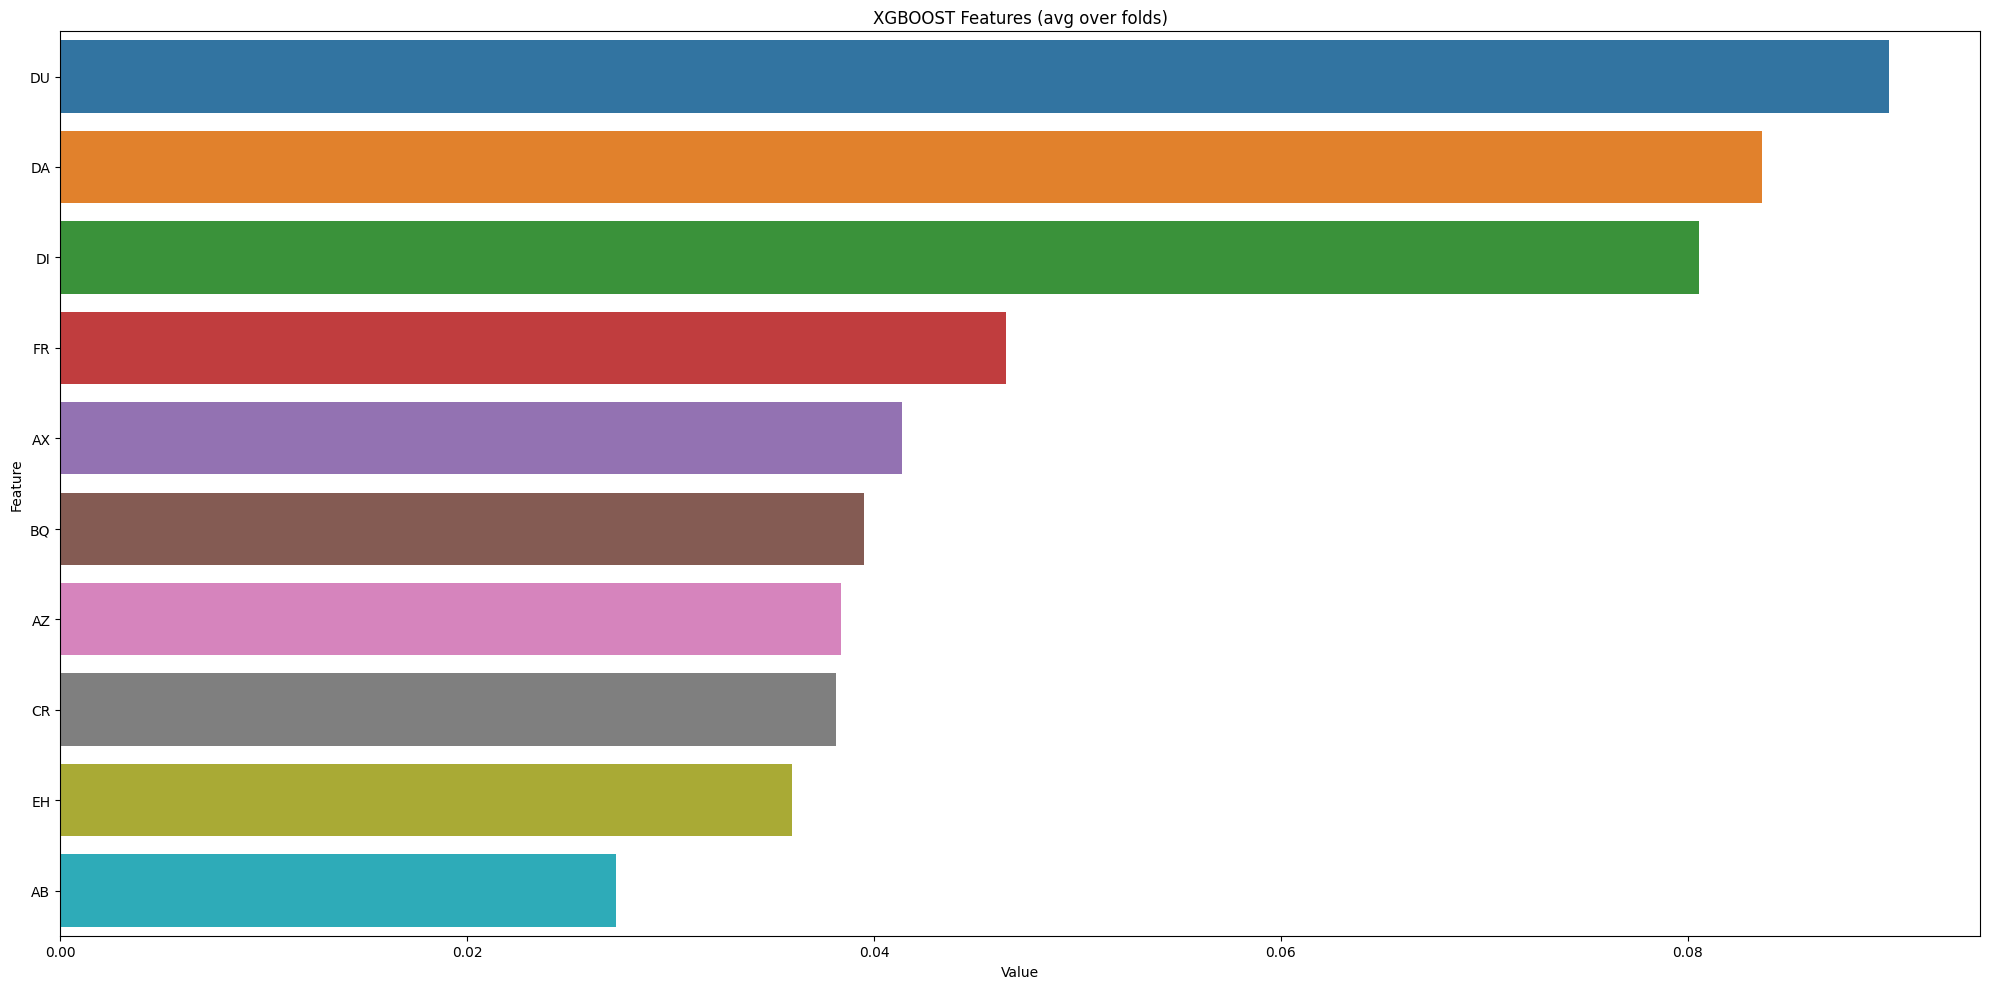

In [25]:

feature_imp = pd.DataFrame(sorted(zip(model[1].feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
plt.title('XGBOOST Features (avg over folds)')
plt.tight_layout()
plt.show()

In [26]:
# compute SHAP values
import shap
%time 
clf = model[1]
shap_values = shap.TreeExplainer(clf).shap_values(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


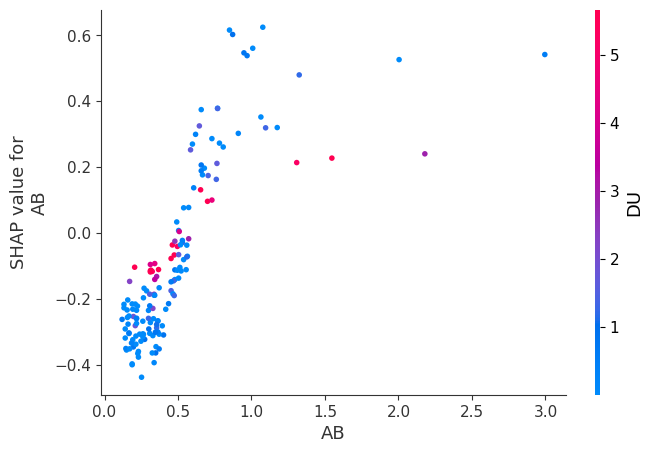

In [27]:
shap.dependence_plot("AB", shap_values, X_test,feature_names=X.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


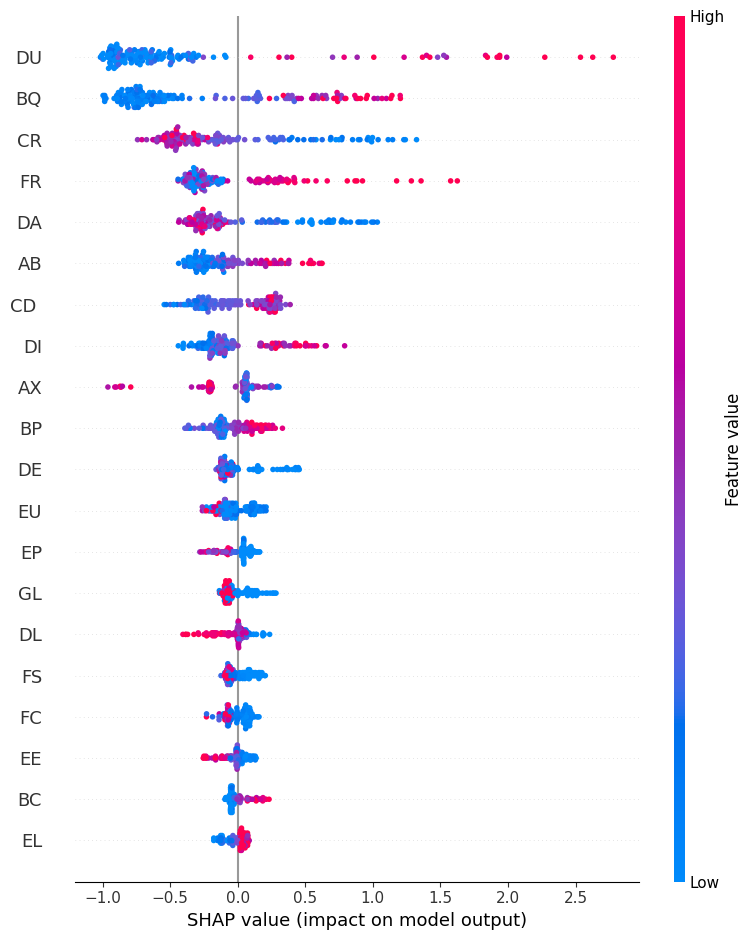

In [28]:
f3 = plt.figure()
shap.summary_plot(shap_values, features=X_test, max_display=20, feature_names=X.iloc[0,:].index)
f3.show()

In [29]:

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[110,  15],
       [  3,  27]])

In [30]:
def plot_confusion_matrix(cf_matrix):
    plt.figure(figsize=(9, 7))
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='nipy_spectral')
 
    plt.title("Prédiction avec les données normalisées")
    plt.show()

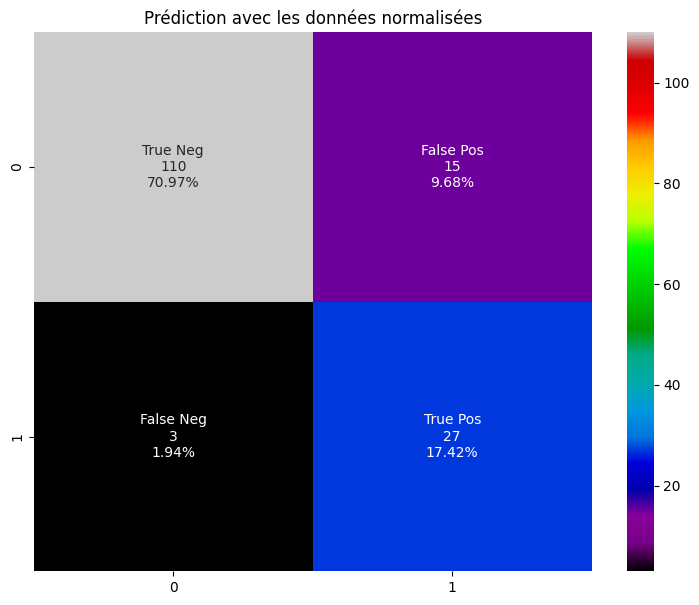

In [31]:
plot_confusion_matrix(cf_matrix)

In [32]:
# Function to plot ROC and Precision-Recall curves
def ROC_PR_curves(test_labels, list_pred_proba, models_name):
    '''Function to plot ROC and PR curves
    test_labels --> True labels to predicts, y_test for example 1_D
    list_pred_proba --> models predicts probalbility 1-D
    models_name --> list of models names in the same order than list_predict_proba'''
    # figure init
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    plt.suptitle('ROC / PR curves for our models (validation data)', fontweight='bold')
    ax1.plot([0,1], [0,1], 'k--')
    ax2.plot([0,1], [0,0], 'k--')
    ax1.set_title('ROC')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax2.set_title('Precision / Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    # counter for getting models names
    count=0
    for pred_prob in list_pred_proba:
        # fpr and tpr calcul
        fpr, tpr, _ = roc_curve(test_labels, pred_prob)
        # Precision and recall calcul
        pr, rec, _ = precision_recall_curve(test_labels, pred_prob)
        # Plot ROC curve
        ax1.plot(fpr, tpr, label=f'{models_name[count]} / AUC={roc_auc_score(test_labels, pred_prob):.3f}')
        # Plot PR curve
        ax2.plot(rec, pr, label=models_name[count])
        count+=1
    ax1.legend()
    ax2.legend() 
    plt.show()

In [33]:
y_pred_prob_list

[(array([1.        , 1.        , 1.        , 0.        , 1.        ,
         0.        , 0.        , 1.        , 0.38461538, 0.        ,
         0.38461538, 1.        , 1.        , 0.        , 0.38461538,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         1.        , 1.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.38461538, 0.        ,
         0.        , 0.        , 1.        , 0.        , 1.        ,
         1.        , 0.38461538, 1.        , 0.38461538, 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ,
         1.        , 0.38461538, 0.        , 0.38461538, 1.        ,
         0.        , 0.        , 0.        , 1.        , 0.38461538,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.38461538, 0.        ,
         0.        , 0.        , 0

In [34]:
(df_test)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
prediction = model.predict_proba(df_test)
sample_submission[['class_0', 'class_1']] = prediction
sample_submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.275091,0.724909
1,010ebe33f668,0.275091,0.724909
2,02fa521e1838,0.275091,0.724909
3,040e15f562a2,0.275091,0.724909
4,046e85c7cc7f,0.275091,0.724909


In [36]:
sample_submission.to_csv('submission.csv', index=False)